# Chatbot Evaluation #

In [22]:
#General imports
import pandas as pd
import time
from importlib import reload
import evaltools
reload(evaltools)
from sqltr import SQLTestRun
from itertools import product
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score

from sklearn.ensemble import RandomForestRegressor

import numpy as np


In [2]:
#read input test file:
init_df = pd.read_csv('./data/eval_set.csv')
init_df

,is_sql,num_join,indirect_level,difficulty_level,specified_response_field,text_query,expected_sql
0,1,0,0.5,0.5,0.0,Show all invoices that were made during Christ...,SELECT * FROM invoice WHERE (TO_CHAR(invoice_d...
1,1,1,0.5,1.5,0.0,Find the top 3 artists by total albums,"SELECT AR.name, COUNT(AR.name) as TotalAlbums ..."
2,1,1,0.5,1.5,0.0,list classic composers and their corresponding...,"SELECT T.composer, AVG(T.milliseconds) from tr..."
3,1,0,0.0,0.0,0.0,list all the countries our customers are from,SELECT distinct country from customer
4,1,0,0.5,0.5,1.0,What is the total invoice amount as total_amou...,"SELECT billing_country, SUM(total) as total_am..."
5,1,0,0.0,0.0,0.0,What playlists are there?,SELECT name from playlist
6,1,1,0.5,1.5,1.0,"Who reports to Andrew Adams, provide the name ...","SELECT CONCAT(last_name, ', ', first_name) AS..."
7,1,2,0.5,2.5,1.0,List all the play_list_name and track_name of ...,"SELECT distinct P.name as play_list_name, T.na..."
8,1,0,0.0,0.0,0.0,How many staff does the store have?,SELECT COUNT(*) from employee
9,0,0,NaN,NaN,NaN,Are we ready?,NaN


In [ ]:
#setup parameters, then permute the test rows of all combinations of the parameters

methods = ["rag", "tag"]
providers = ["OpenAI", "Claude"]
temperatures = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]


combinations = [
    {"method": method, "provider": provider, "temperature": temperature}
    for method, provider, temperature in product(methods, providers, temperatures)
]

### Section 1: Initial Query Evaluation ###

In this section we evaluate: 

    1. Latency of query generation. 
    2. Whether the generation result are SQL if the user query is translatable to SQL, or error message if the user query is not SQL query related.
    3. For text query that can be translated into SQL, evaluate whehter the SQL is valid PostGRESQL SQL, if not, report what error. 

In [ ]:
df_rows = []

for combination in combinations:
    method = combination["method"]
    provider = combination["provider"]
    temperature = combination["temperature"]
    
    for i in range(len(init_df)):
        text_query = init_df.iloc[i]['text_query']
        expected_sql = init_df.iloc[i]['expected_sql']
        expected_is_query = (init_df.iloc[i]['is_sql'] == 1)
        difficulty = init_df.iloc[i]['difficulty_level']
        specified_response_field = init_df.iloc[i]['specified_response_field']
 
        if(method == "rag"):
            start_time = time.perf_counter()
            generated_sql = evaltools.gen_rag_query(text_query, provider, temperature)
            end_time = time.perf_counter()
        else:
            start_time = time.perf_counter()
            generated_sql = await evaltools.gen_tag_query(text_query, provider, temperature)
            end_time = time.perf_counter()
            
        generation_latency = (end_time - start_time)*1000 # convert seconds to milli seconds
        generated_is_sql = evaltools.is_sql_check(generated_sql)

        is_type_correct = evaltools.confirm_type(generated_sql, expected_is_query)
        if(generated_is_sql):
            lintEval = evaltools.check_sql_errors(generated_sql)
            isValidSQL = lintEval["isValid"]
            formatIssue = lintEval["errMessage"]
        else: 
            isValidSQL = "N/A"
            formatIssue = "N/A"

        new_row = {
            "method": method, "provider": provider, "temperature": temperature, "difficulty": difficulty,"specified_response_field":specified_response_field,
            "text_query": text_query, "expected_sql": expected_sql, "expected_is_query": expected_is_query,
            "generated_sql": generated_sql, "generated_is_sql": generated_is_sql, "is_type_correct": is_type_correct,
            "generation_latency": generation_latency, "isValidSQL": isValidSQL, "formatIssue": formatIssue
        }
        # Append the row
        df_rows.append(new_row)
        

eval_df = pd.DataFrame(df_rows)


Error tokenizing 'type_id = mt.media_type_id WHERE p.name = 'Music''


In [6]:
eval_df.head()

,method,provider,temperature,difficulty,specified_response_field,text_query,expected_sql,expected_is_query,generated_sql,generated_is_sql,is_type_correct,generation_latency,isValidSQL,formatIssue
0,rag,OpenAI,0.0,0.5,0.0,Show all invoices that were made during Christ...,SELECT * FROM invoice WHERE (TO_CHAR(invoice_d...,True,SELECT * FROM invoice WHERE invoice_date IN ('...,True,True,7186.709252,True,
1,rag,OpenAI,0.0,1.5,0.0,Find the top 3 artists by total albums,"SELECT AR.name, COUNT(AR.name) as TotalAlbums ...",True,"SELECT artist.name, COUNT(album.album_id) AS t...",True,True,3122.627130,True,
2,rag,OpenAI,0.0,1.5,0.0,list classic composers and their corresponding...,"SELECT T.composer, AVG(T.milliseconds) from tr...",True,"SELECT composer, AVG(milliseconds) as average_...",True,True,1642.117628,True,
3,rag,OpenAI,0.0,0.0,0.0,list all the countries our customers are from,SELECT distinct country from customer,True,SELECT DISTINCT country FROM customer;,True,True,1350.096696,True,
4,rag,OpenAI,0.0,0.5,1.0,What is the total invoice amount as total_amou...,"SELECT billing_country, SUM(total) as total_am...",True,"SELECT billing_country, SUM(total) AS total_am...",True,True,1356.925892,True,


In [6]:
eval_df.to_csv("eval_df.csv", index=False)

/tmp/ipykernel_6388/2340043506.py:30: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed in 3.10. Use buffer_rgba instead.
  image1 = np.frombuffer(g1.figure.canvas.tostring_rgb(), dtype=np.uint8)
/tmp/ipykernel_6388/2340043506.py:36: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed in 3.10. Use buffer_rgba instead.
  image2 = np.frombuffer(g2.figure.canvas.tostring_rgb(), dtype=np.uint8)


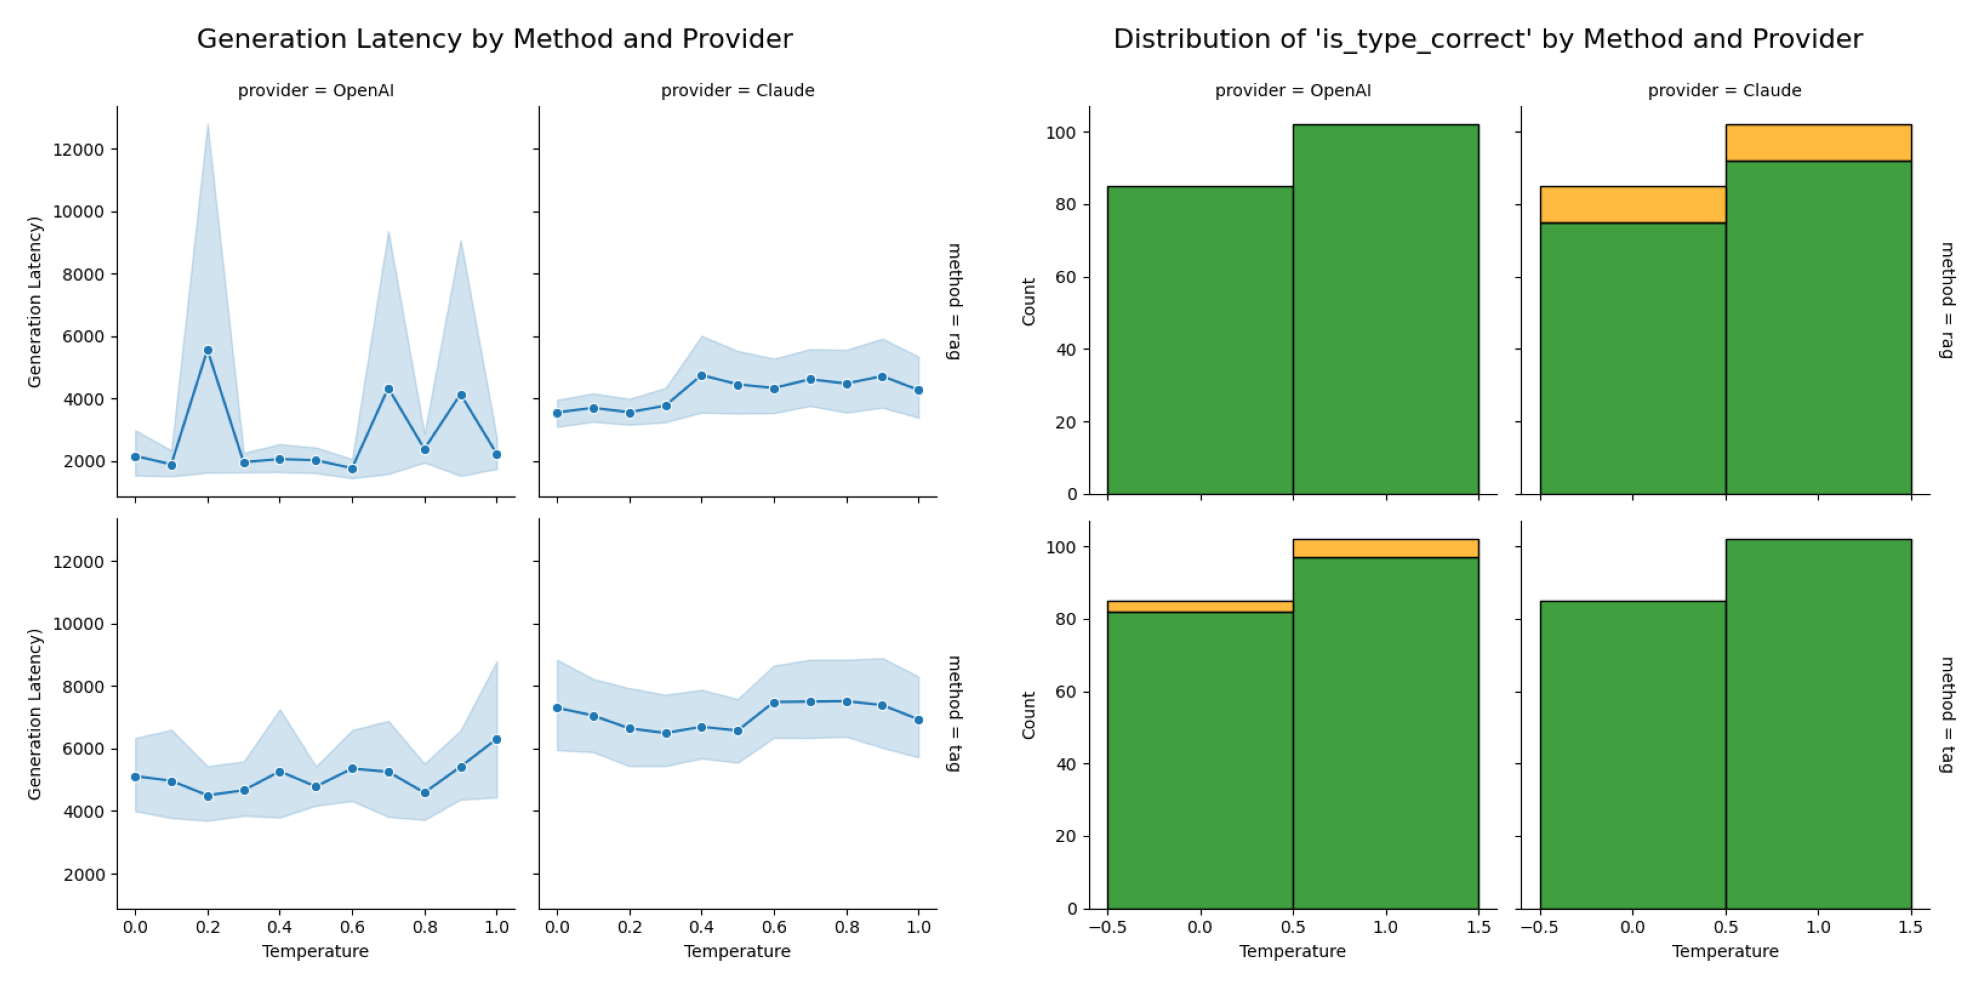

In [ ]:
#generate latency and type correctness plots
g1 = sns.FacetGrid(eval_df, row="method", col="provider", margin_titles=True, height=4, aspect=1)
g1.map_dataframe(sns.lineplot, x="temperature", y="generation_latency", marker="o")
g1.set_axis_labels("Temperature", "Generation Latency)")
g1.set_titles("{row_name} | {col_name}")
g1.figure.subplots_adjust(top=0.9)
g1.figure.suptitle("Generation Latency by Method and Provider", fontsize=16)

plt.close(g1.figure)

custom_palette = {True: "green", False: "orange"}
g2 = sns.FacetGrid(eval_df, row="method", col="provider", margin_titles=True, height=4, aspect=1)
g2.map_dataframe(
    sns.histplot,
    x="temperature",
    hue="is_type_correct",
    multiple="stack",
    discrete=True,
    palette=custom_palette,
)
g2.set_axis_labels("Temperature", "Count")
g2.set_titles("{row_name} | {col_name}")
g2.figure.subplots_adjust(top=0.9)
g2.figure.suptitle("Distribution of 'is_type_correct' by Method and Provider", fontsize=16)

plt.close(g2.figure)

fig, axs = plt.subplots(1, 2, figsize=(20, 10))

g1.figure.canvas.draw()
image1 = np.frombuffer(g1.figure.canvas.tostring_rgb(), dtype=np.uint8)
image1 = image1.reshape(g1.figure.canvas.get_width_height()[::-1] + (3,))
axs[0].imshow(image1)
axs[0].axis("off")  # Turn off axes for the FacetGrid plot

g2.figure.canvas.draw()
image2 = np.frombuffer(g2.figure.canvas.tostring_rgb(), dtype=np.uint8)
image2 = image2.reshape(g2.figure.canvas.get_width_height()[::-1] + (3,))
axs[1].imshow(image2)
axs[1].axis("off")  # Turn off axes for the FacetGrid plot

plt.tight_layout()
plt.show()

### Further Analyze Queries that Can be Translated to SQL ###

In [ ]:
# filter out only the rows have SQL generated. 
sql_df = eval_df[(eval_df['generated_is_sql'] == True) & (eval_df['expected_is_query'] == True)].copy()

In [9]:
sql_df.head(10)

,method,provider,temperature,difficulty,specified_response_field,text_query,expected_sql,expected_is_query,generated_sql,generated_is_sql,is_type_correct,generation_latency,isValidSQL,formatIssue
0,rag,OpenAI,0.0,0.5,0.0,Show all invoices that were made during Christ...,SELECT * FROM invoice WHERE (TO_CHAR(invoice_d...,True,SELECT * FROM invoice WHERE invoice_date IN ('...,True,True,7186.709252,True,
1,rag,OpenAI,0.0,1.5,0.0,Find the top 3 artists by total albums,"SELECT AR.name, COUNT(AR.name) as TotalAlbums ...",True,"SELECT artist.name, COUNT(album.album_id) AS t...",True,True,3122.627130,True,
2,rag,OpenAI,0.0,1.5,0.0,list classic composers and their corresponding...,"SELECT T.composer, AVG(T.milliseconds) from tr...",True,"SELECT composer, AVG(milliseconds) as average_...",True,True,1642.117628,True,
3,rag,OpenAI,0.0,0.0,0.0,list all the countries our customers are from,SELECT distinct country from customer,True,SELECT DISTINCT country FROM customer;,True,True,1350.096696,True,
4,rag,OpenAI,0.0,0.5,1.0,What is the total invoice amount as total_amou...,"SELECT billing_country, SUM(total) as total_am...",True,"SELECT billing_country, SUM(total) AS total_am...",True,True,1356.925892,True,
5,rag,OpenAI,0.0,0.0,0.0,What playlists are there?,SELECT name from playlist,True,SELECT name FROM playlist;,True,True,1018.080478,True,
6,rag,OpenAI,0.0,1.5,1.0,"Who reports to Andrew Adams, provide the name ...","SELECT CONCAT(last_name, ', ', first_name) AS...",True,"SELECT CONCAT(last_name, ', ', first_name) AS ...",True,True,1528.799481,True,
7,rag,OpenAI,0.0,2.5,1.0,List all the play_list_name and track_name of ...,"SELECT distinct P.name as play_list_name, T.na...",True,"SELECT playlist.name AS play_list_name, track....",True,True,1980.316648,True,
8,rag,OpenAI,0.0,0.0,0.0,How many staff does the store have?,SELECT COUNT(*) from employee,True,SELECT COUNT(*) FROM employee;,True,True,1031.501023,True,
12,rag,OpenAI,0.0,4.0,1.0,What are the customer first_name and last_name...,"SELECT distinct c.first_name, c.last_name from...",True,"SELECT customer.first_name, customer.last_name...",True,True,3153.233330,True,


In [19]:
sqlTestRun = SQLTestRun()

In [ ]:

#Calculate Metric Scores
for i, row in sql_df.iterrows():
    expected_sql = row['expected_sql']
    generated_sql = row['generated_sql']
    if row['isValidSQL']:
        valid_score = 1
    else: 0

    sql_sim_score = evaltools.sql_compare_score(expected_sql, generated_sql)
    sql_length_score = evaltools.sql_length_score(expected_sql, generated_sql)

    edf = sqlTestRun.run_sql_result(expected_sql)
    gdf = sqlTestRun.run_sql_result(generated_sql)

    try:
        edf = sqlTestRun.run_sql_result(expected_sql)
        gdf = sqlTestRun.run_sql_result(generated_sql)
        qr_response_comp_score = evaltools.qr_compare(edf, gdf)
        cosin_sim_score = evaltools.cosin_sim(edf, gdf)
    except Exception as e:
        qr_response_comp_score = {"cols_sim_score": 0, "rows_sim_score": 0, "total_sim_score": 0}

    qr_response_score = qr_response_comp_score.get("total_sim_score")

    
    total_score = ((cosin_sim_score*0.2)+(sql_sim_score*0.2)+(sql_length_score*0.01)+(qr_response_score*0.6))*valid_score

    sql_df.loc[i, 'sql_sim_score'] = sql_sim_score
    sql_df.loc[i, 'sql_length_score'] = sql_length_score
    sql_df.loc[i, 'qr_response_score'] = qr_response_score
    sql_df.loc[i, 'cosin_sim_score'] = cosin_sim_score
    sql_df.loc[i, 'total_score'] = total_score

Error: One or both DataFrames are empty
Error: One or both DataFrames are empty
Error: One or both DataFrames are empty
Error: One or both DataFrames are empty
Error: One or both DataFrames are empty
Error: No common columns found
Error: One or both DataFrames are empty
Error: No common columns found
Error: One or both DataFrames are empty
Error: One or both DataFrames are empty
Error: One or both DataFrames are empty
Error: One or both DataFrames are empty
Error: One or both DataFrames are empty
Error: One or both DataFrames are empty
Error: One or both DataFrames are empty
Error: One or both DataFrames are empty
Error: One or both DataFrames are empty
Error: One or both DataFrames are empty
Error: One or both DataFrames are empty
Error: One or both DataFrames are empty
Error: One or both DataFrames are empty
Error: One or both DataFrames are empty
Error: One or both DataFrames are empty
Error: No common columns found
Error: One or both DataFrames are empty
Error: One or both DataFram

In [24]:
sql_df

,method,provider,temperature,difficulty,specified_response_field,text_query,expected_sql,expected_is_query,generated_sql,generated_is_sql,is_type_correct,generation_latency,isValidSQL,formatIssue,sql_sim_score,sql_length_score,qr_response_score,cosin_sim_score,total_score
0,rag,OpenAI,0.0,0.5,0.0,Show all invoices that were made during Christ...,SELECT * FROM invoice WHERE (TO_CHAR(invoice_d...,True,SELECT * FROM invoice WHERE invoice_date IN ('...,True,True,7186.709252,True,,0.780000,-6.0,0.400000,0.000000,0.336000
1,rag,OpenAI,0.0,1.5,0.0,Find the top 3 artists by total albums,"SELECT AR.name, COUNT(AR.name) as TotalAlbums ...",True,"SELECT artist.name, COUNT(album.album_id) AS t...",True,True,3122.627130,True,,0.817869,-15.0,0.750000,0.333333,0.530241
2,rag,OpenAI,0.0,1.5,0.0,list classic composers and their corresponding...,"SELECT T.composer, AVG(T.milliseconds) from tr...",True,"SELECT composer, AVG(milliseconds) as average_...",True,True,1642.117628,True,,0.717557,-10.0,0.150000,0.000000,0.133511
3,rag,OpenAI,0.0,0.0,0.0,list all the countries our customers are from,SELECT distinct country from customer,True,SELECT DISTINCT country FROM customer;,True,True,1350.096696,True,,1.000000,0.0,1.000000,0.041667,0.808333
4,rag,OpenAI,0.0,0.5,1.0,What is the total invoice amount as total_amou...,"SELECT billing_country, SUM(total) as total_am...",True,"SELECT billing_country, SUM(total) AS total_am...",True,True,1356.925892,True,,1.000000,0.0,1.000000,0.096254,0.819251
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
743,tag,Claude,1.0,4.0,1.0,What are the customer first_name and last_name...,"SELECT distinct c.first_name, c.last_name from...",True,"SELECT DISTINCT c.first_name, c.last_name FROM...",True,True,8298.270058,True,,0.332143,-62.0,1.000000,0.034483,0.053325
744,tag,Claude,1.0,0.5,0.0,How many staff were born before 1970?,select count(*) from employee where birth_date...,True,SELECT COUNT(*) as count FROM employee WHERE b...,True,True,4374.544359,True,,0.939130,-7.0,1.000000,1.000000,0.917826
745,tag,Claude,1.0,0.5,0.0,"Find the album whose title contains ""lost""",select * from album a where LOWER(title) like...,True,"SELECT title, artist.name as artist_name FROM ...",True,True,5348.685303,True,,0.511364,-84.0,0.666667,1.000000,-0.137727
746,tag,Claude,1.0,1.0,1.0,Give me all album titles by the artist BackBeat,select title from album a join artist a2 on a...,True,SELECT a.title FROM album a JOIN artist ar ON ...,True,True,5641.854019,True,,0.940476,0.0,1.000000,1.000000,0.988095


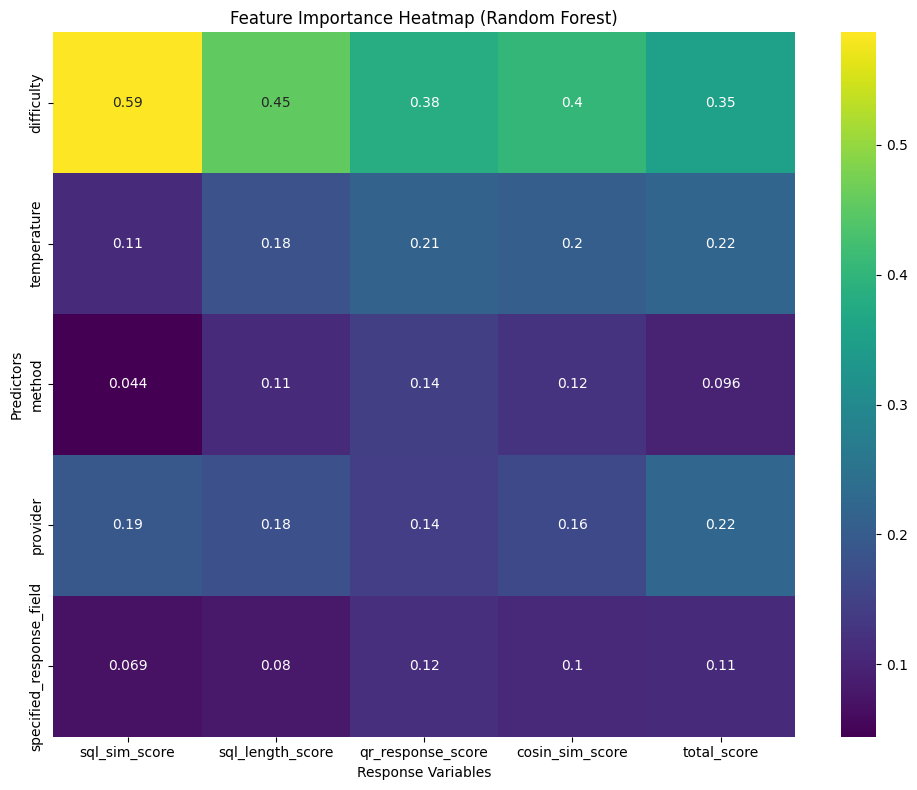

In [ ]:
#Create Feature Importance Heatmap:
predictors = ['difficulty', 'temperature', 'method', 'provider', 'specified_response_field']
response_vars = ['sql_sim_score', 'sql_length_score', 'qr_response_score', 'cosin_sim_score', 'total_score']

data_encoded = sql_df.copy()
data_encoded['method'] = data_encoded['method'].astype('category').cat.codes
data_encoded['provider'] = data_encoded['provider'].astype('category').cat.codes

importances = {}

for response in response_vars:
    X = data_encoded[predictors]  
    y = data_encoded[response]   

    model = RandomForestRegressor(random_state=42)
    model.fit(X, y)

    importances[response] = model.feature_importances_

importance_df = pd.DataFrame(importances, index=predictors)

plt.figure(figsize=(10, 8))
sns.heatmap(importance_df, annot=True, cmap="viridis", cbar=True) 
plt.title("Feature Importance Heatmap (Random Forest)")
plt.xlabel("Response Variables")
plt.ylabel("Predictors")
plt.tight_layout()
plt.show()

In [48]:

import statsmodels.api as sm
data_encoded = sql_df.copy()
data_encoded['method'] = data_encoded['method'].astype('category').cat.codes
data_encoded['provider'] = data_encoded['provider'].astype('category').cat.codes

# predictors = ['provider', 'method','temperature','difficulty']  # Replace with your identified variables
response = 'qr_response_score'  
predictors = ['provider', 'method','temperature'] 
# Prepare data for regression
X = data_encoded[predictors]  
y = data_encoded[response]    
X = sm.add_constant(X)

model = sm.OLS(y, X).fit()

print(model.pvalues)
# print(model.summary())

model.summary()

const          1.153543e-55
provider       1.356059e-03
method         2.209987e-01
temperature    7.550562e-01
dtype: float64


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      qr_response_score   R-squared:                       0.019
Model:                            OLS   Adj. R-squared:                  0.014
Method:                 Least Squares   F-statistic:                     3.986
Date:                Sun, 08 Dec 2024   Prob (F-statistic):            0.00791
Time:                        10:14:09   Log-Likelihood:                -264.37
No. Observations:                 616   AIC:                             536.7
Df Residuals:                     612   BIC:                             554.4
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.6149      0.035     17.453      0.000       0.546       0.684
provider        0.0967      0.030      3.219      0.001       0.038       0.156
method          0.0368      0.030      1.225      0.221      -0.022       0.096
temperature    -0.0148      0.048     -0.312      0.755      -0.108       0.078
==============================================================================
Omnibus:                      189.318   Durbin-Watson:                   2.080
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               79.665
Skew:                          -0.716   Prob(JB):                     5.02e-18
Kurtosis:                       1.972   Cond. No.                         4.99
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

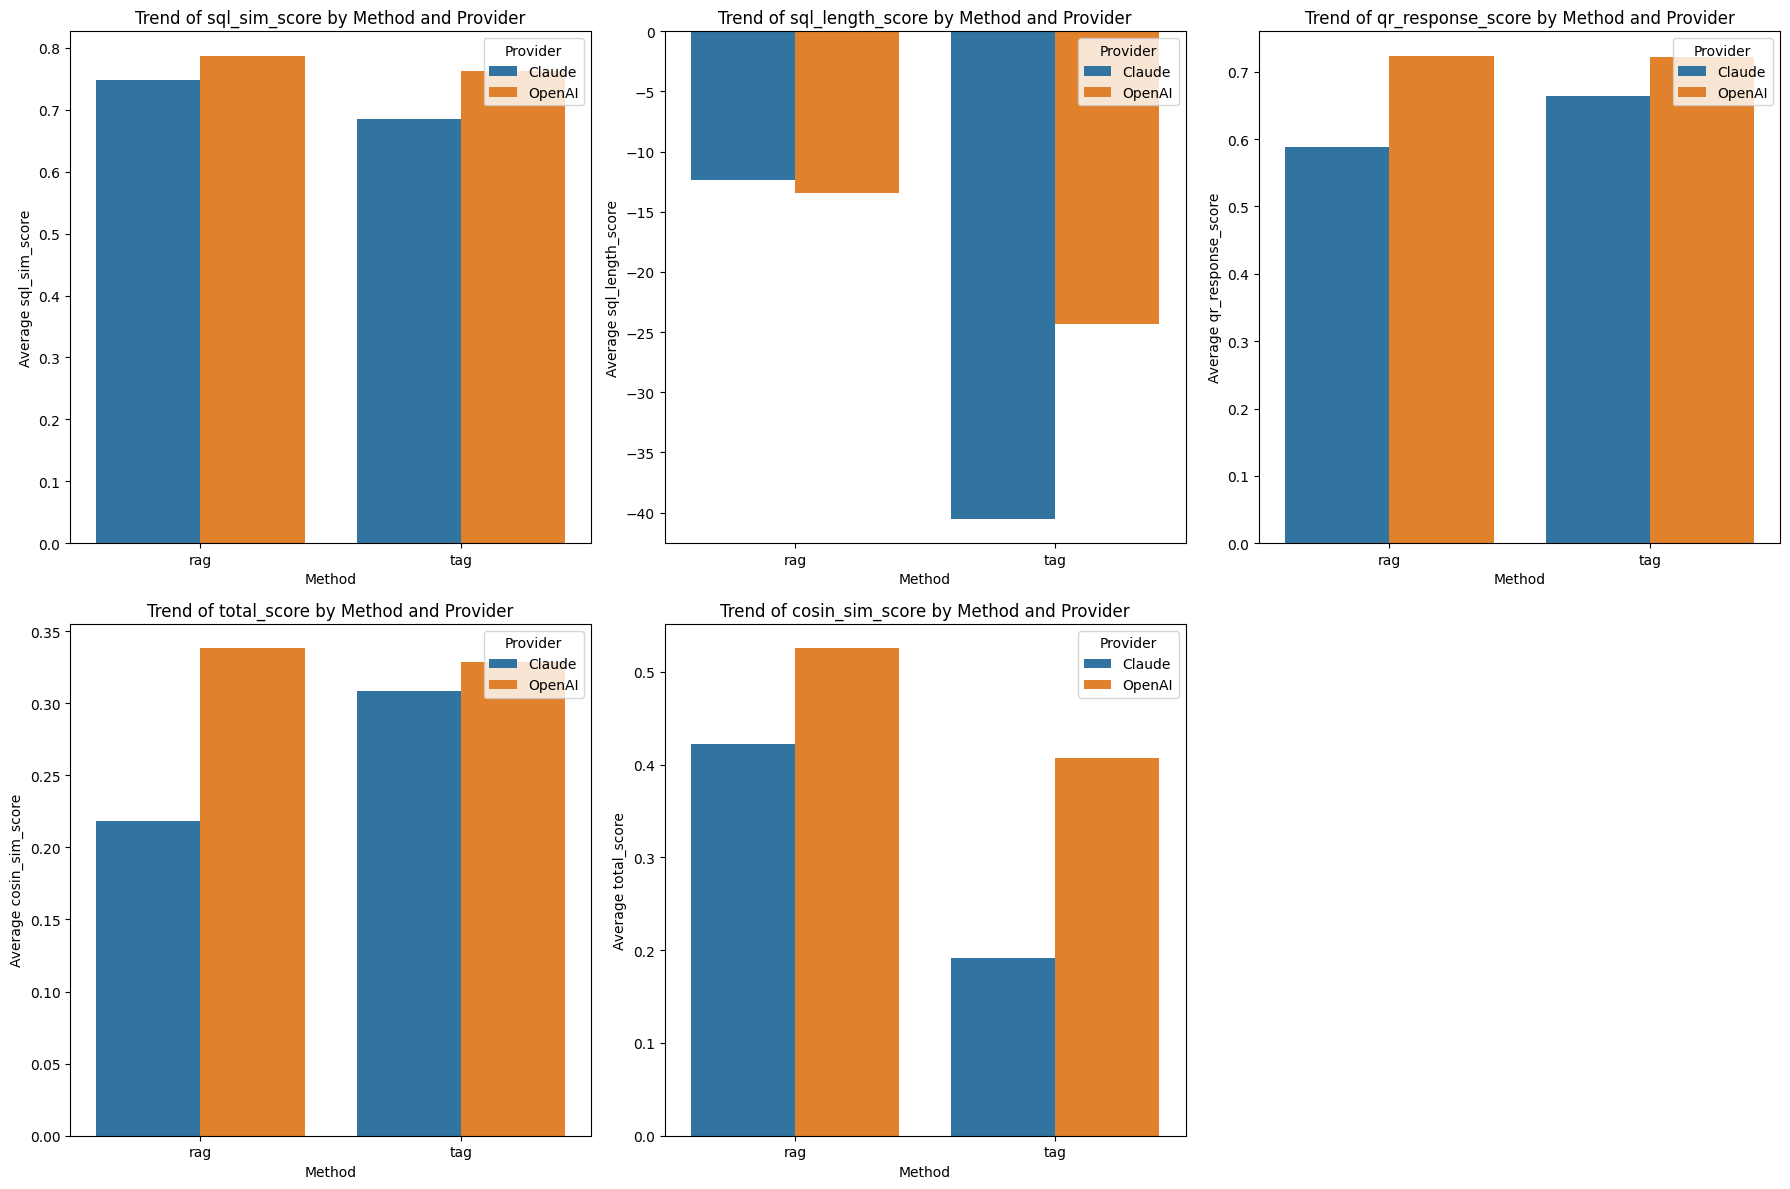

In [ ]:
#Response Variable Trends by Category
data = sql_df.copy()
response_vars = ['sql_sim_score', 'sql_length_score', 'qr_response_score','cosin_sim_score', 'total_score']

# Encode categorical variables
data_encoded = data.copy()
data_encoded['method'] = data_encoded['method'].astype('category').cat.codes
data_encoded['provider'] = data_encoded['provider'].astype('category').cat.codes

# Group data by method and provider, calculating the mean for each response variable
grouped_data = data_encoded.groupby(['method', 'provider'])[response_vars].mean().reset_index()

# Map numeric codes back to the original provider names for better readability
method_mapping = dict(enumerate(data['method'].astype('category').cat.categories))
provider_mapping = dict(enumerate(data['provider'].astype('category').cat.categories))
grouped_data['method'] = grouped_data['method'].map(method_mapping)
grouped_data['provider'] = grouped_data['provider'].map(provider_mapping)

# Create subplots for each response variable trend grouped by method and provider
fig, axes = plt.subplots(2, 3, figsize=(18, 12)) 
axes = axes.flatten()  


titles = [
    "Trend of sql_sim_score by Method and Provider",
    "Trend of sql_length_score by Method and Provider",
    "Trend of qr_response_score by Method and Provider",
    "Trend of total_score by Method and Provider",
    "Trend of cosin_sim_score by Method and Provider"
]


for i, response in enumerate(response_vars):
    sns.barplot(
        x='method', y=response, hue='provider', data=grouped_data,
        palette='tab10', ax=axes[i]
    )
    axes[i].set_title(titles[i])
    axes[i].set_xlabel("Method")
    axes[i].set_ylabel(f"Average {response}")
    axes[i].legend(title="Provider", loc='upper right')


if len(response_vars) < len(axes):
    for j in range(len(response_vars), len(axes)):
        fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

/tmp/ipykernel_6388/1136971149.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=sql_df, x='method', y=response, ax=axes[i, 0], palette=boxplot_palette)
/tmp/ipykernel_6388/1136971149.py:16: UserWarning: The palette list has more values (5) than needed (2), which may not be intended.
  sns.boxplot(data=sql_df, x='method', y=response, ax=axes[i, 0], palette=boxplot_palette)
/tmp/ipykernel_6388/1136971149.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=sql_df, x='provider', y=response, ax=axes[i, 1], palette=boxplot_palette)
/tmp/ipykernel_6388/1136971149.py:22: UserWarning: The palette list has more values (5) than needed (2), which may not be intended.
  sns.boxplot(data=

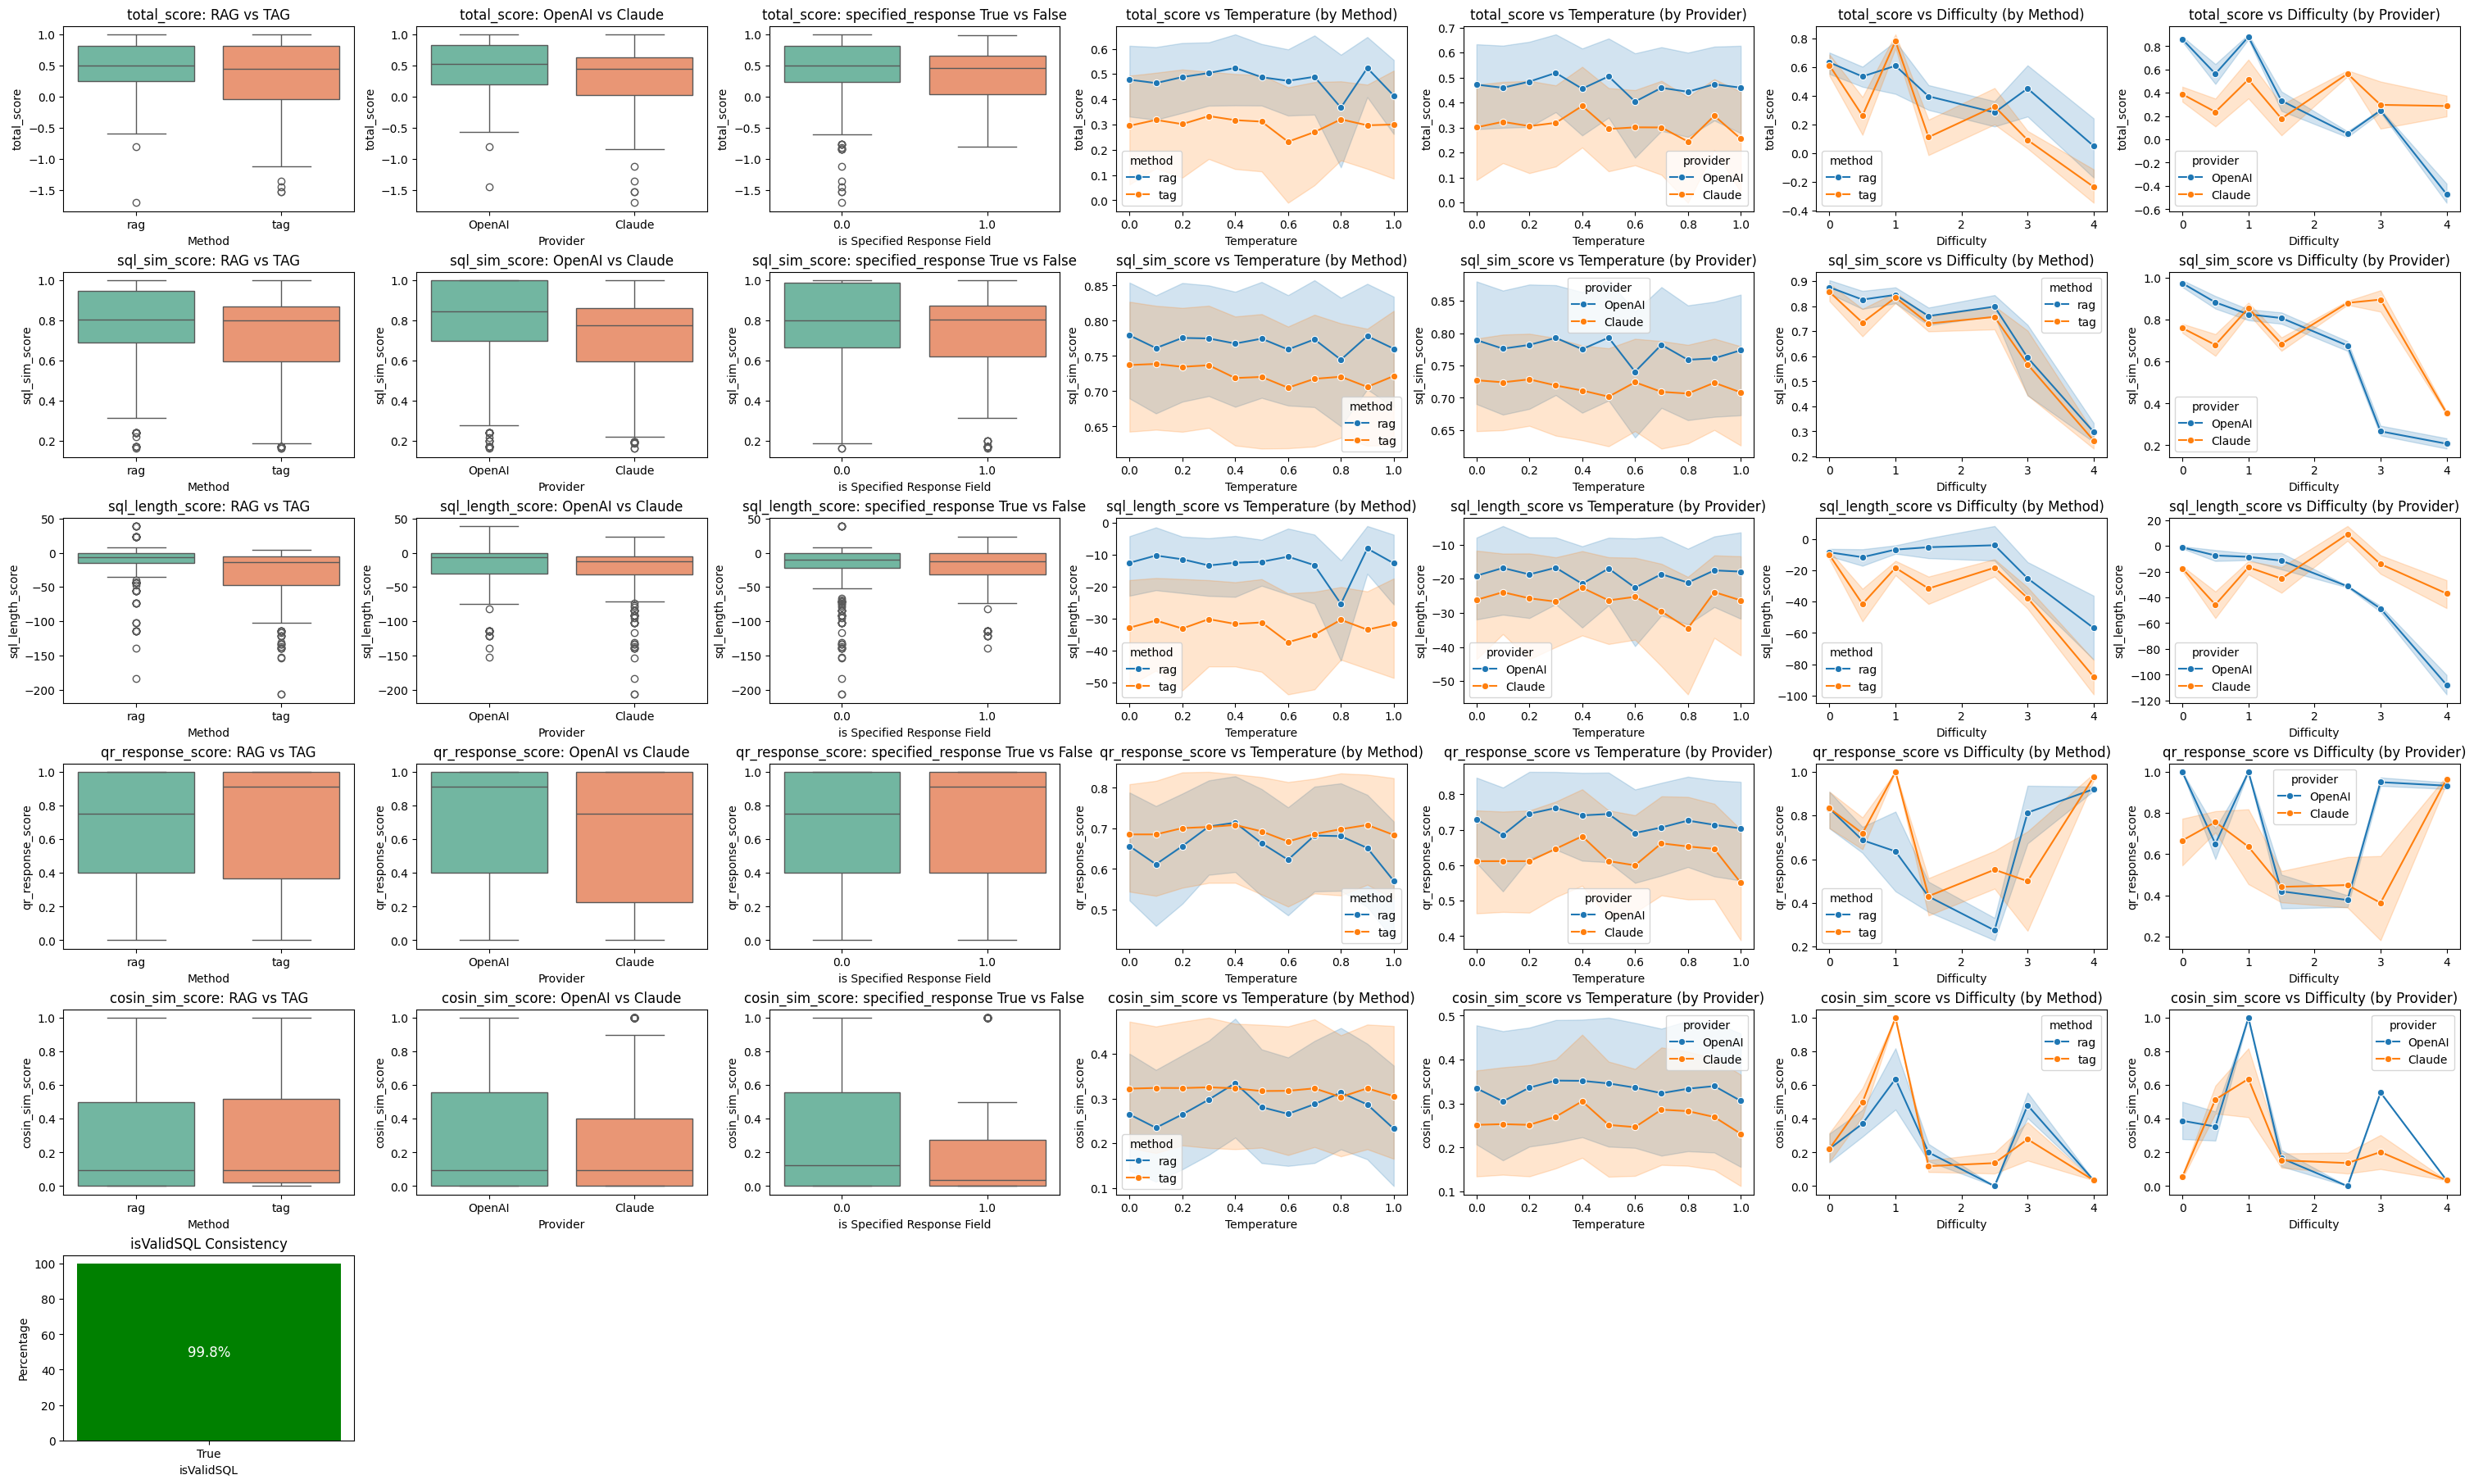

In [ ]:

# List of response variables
response_vars = ['total_score', 'sql_sim_score', 'sql_length_score', 'qr_response_score', 'cosin_sim_score']

# Total number of rows (responses + consistency check)
n_responses = len(response_vars) + 1

# Create a grid of subplots
fig, axes = plt.subplots(n_responses, 7, figsize=(30, 3 * n_responses), constrained_layout=True)

# Color
boxplot_palette = sns.color_palette(["#66c2a5", "#fc8d62", "#8da0cb", "#e78ac3", "#a6d854"])

# Plot response variables against method, provider, and temperature
for i, response in enumerate(response_vars):
    # Marginal boxplot for RAG vs TAG
    sns.boxplot(data=sql_df, x='method', y=response, ax=axes[i, 0], palette=boxplot_palette)
    axes[i, 0].set_title(f'{response}: RAG vs TAG')
    axes[i, 0].set_xlabel('Method')
    axes[i, 0].set_ylabel(response)
    
    # Marginal boxplot for OpenAI vs Claude
    sns.boxplot(data=sql_df, x='provider', y=response, ax=axes[i, 1], palette=boxplot_palette)
    axes[i, 1].set_title(f'{response}: OpenAI vs Claude')
    axes[i, 1].set_xlabel('Provider')
    axes[i, 1].set_ylabel(response)

    # Marginal boxplot for specified_response_field true vs false
    sns.boxplot(data=sql_df, x='specified_response_field', y=response, ax=axes[i, 2], palette=boxplot_palette)
    axes[i, 2].set_title(f'{response}: specified_response True vs False')
    axes[i, 2].set_xlabel('is Specified Response Field')
    axes[i, 2].set_ylabel(response)
    
    # Line plot of response changes with temperature (split by method)
    sns.lineplot(data=sql_df, x='temperature', y=response, hue='method', ax=axes[i, 3], marker='o')
    axes[i, 3].set_title(f'{response} vs Temperature (by Method)')
    axes[i, 3].set_xlabel('Temperature')
    axes[i, 3].set_ylabel(response)
    
    # Line plot of response changes with temperature (split by provider)
    sns.lineplot(data=sql_df, x='temperature', y=response, hue='provider', ax=axes[i, 4], marker='o')
    axes[i, 4].set_title(f'{response} vs Temperature (by Provider)')
    axes[i, 4].set_xlabel('Temperature')
    axes[i, 4].set_ylabel(response)

    # Line plot of response changes with difficulty (split by method)
    sns.lineplot(data=sql_df, x='difficulty', y=response, hue='method', ax=axes[i, 5], marker='o')
    axes[i, 5].set_title(f'{response} vs Difficulty (by Method)')
    axes[i, 5].set_xlabel('Difficulty')
    axes[i, 5].set_ylabel(response)
    
    # Line plot of response changes with temperature (split by provider)
    sns.lineplot(data=sql_df, x='difficulty', y=response, hue='provider', ax=axes[i, 6], marker='o')
    axes[i, 6].set_title(f'{response} vs Difficulty (by Provider)')
    axes[i, 6].set_xlabel('Difficulty')
    axes[i, 6].set_ylabel(response)    

total_rows = len(sql_df)
is_valid_sql_percentage = (sql_df["isValidSQL"].sum() / total_rows) * 100

axes[-1, 0].bar(["True"], [is_valid_sql_percentage], color="green")
axes[-1, 0].set_title("isValidSQL Consistency")
axes[-1, 0].set_ylabel("Percentage")
axes[-1, 0].set_xlabel("isValidSQL")
axes[-1, 0].text(0, is_valid_sql_percentage / 2, f"{is_valid_sql_percentage:.1f}%", ha="center", va="center", color="white", fontsize=12)

# Clear unused subplots in the last row
for ax in axes[-1, 1:]:
    ax.axis("off")

plt.show()


In [51]:
print(sql_df[(sql_df['isValidSQL'] == 0)][["generated_sql", "provider"]])

                                         generated_sql provider
339  Select the distinct `name` values from the `me...   Claude


current formula:  y = 9889021711028.89
(-8632398867792.83) * method_rag + (-8632398867792.87) * method_tag
(-1256622843235.18) * provider_Claude + (-1256622843235.11) * provider_OpenAI
(-0.11) * difficulty + (-0.02) * temperature
current formula:  y = 2307742578659756.00
(-2014491929061497.00) * method_rag + (-2014491929061516.75) * method_tag
(-293250649598261.94) * provider_Claude + (-293250649598254.81) * provider_OpenAI
(-10.32) * difficulty + (-3.54) * temperature
current formula:  y = -7983134901210.65
(6968697885029.79) * method_rag + (6968697885029.79) * method_tag
(1014437016181.51) * provider_Claude + (1014437016181.61) * provider_OpenAI
(-0.02) * difficulty + (0.02) * temperature
current formula:  y = 25273620290443.77
(-22062037839086.47) * method_rag + (-22062037839086.65) * method_tag
(-3211582451356.71) * provider_Claude + (-3211582451356.54) * provider_OpenAI
(-0.15) * difficulty + (-0.03) * temperature
current formula:  y = 25041355511834.30
(-21859287529654.20) * meth

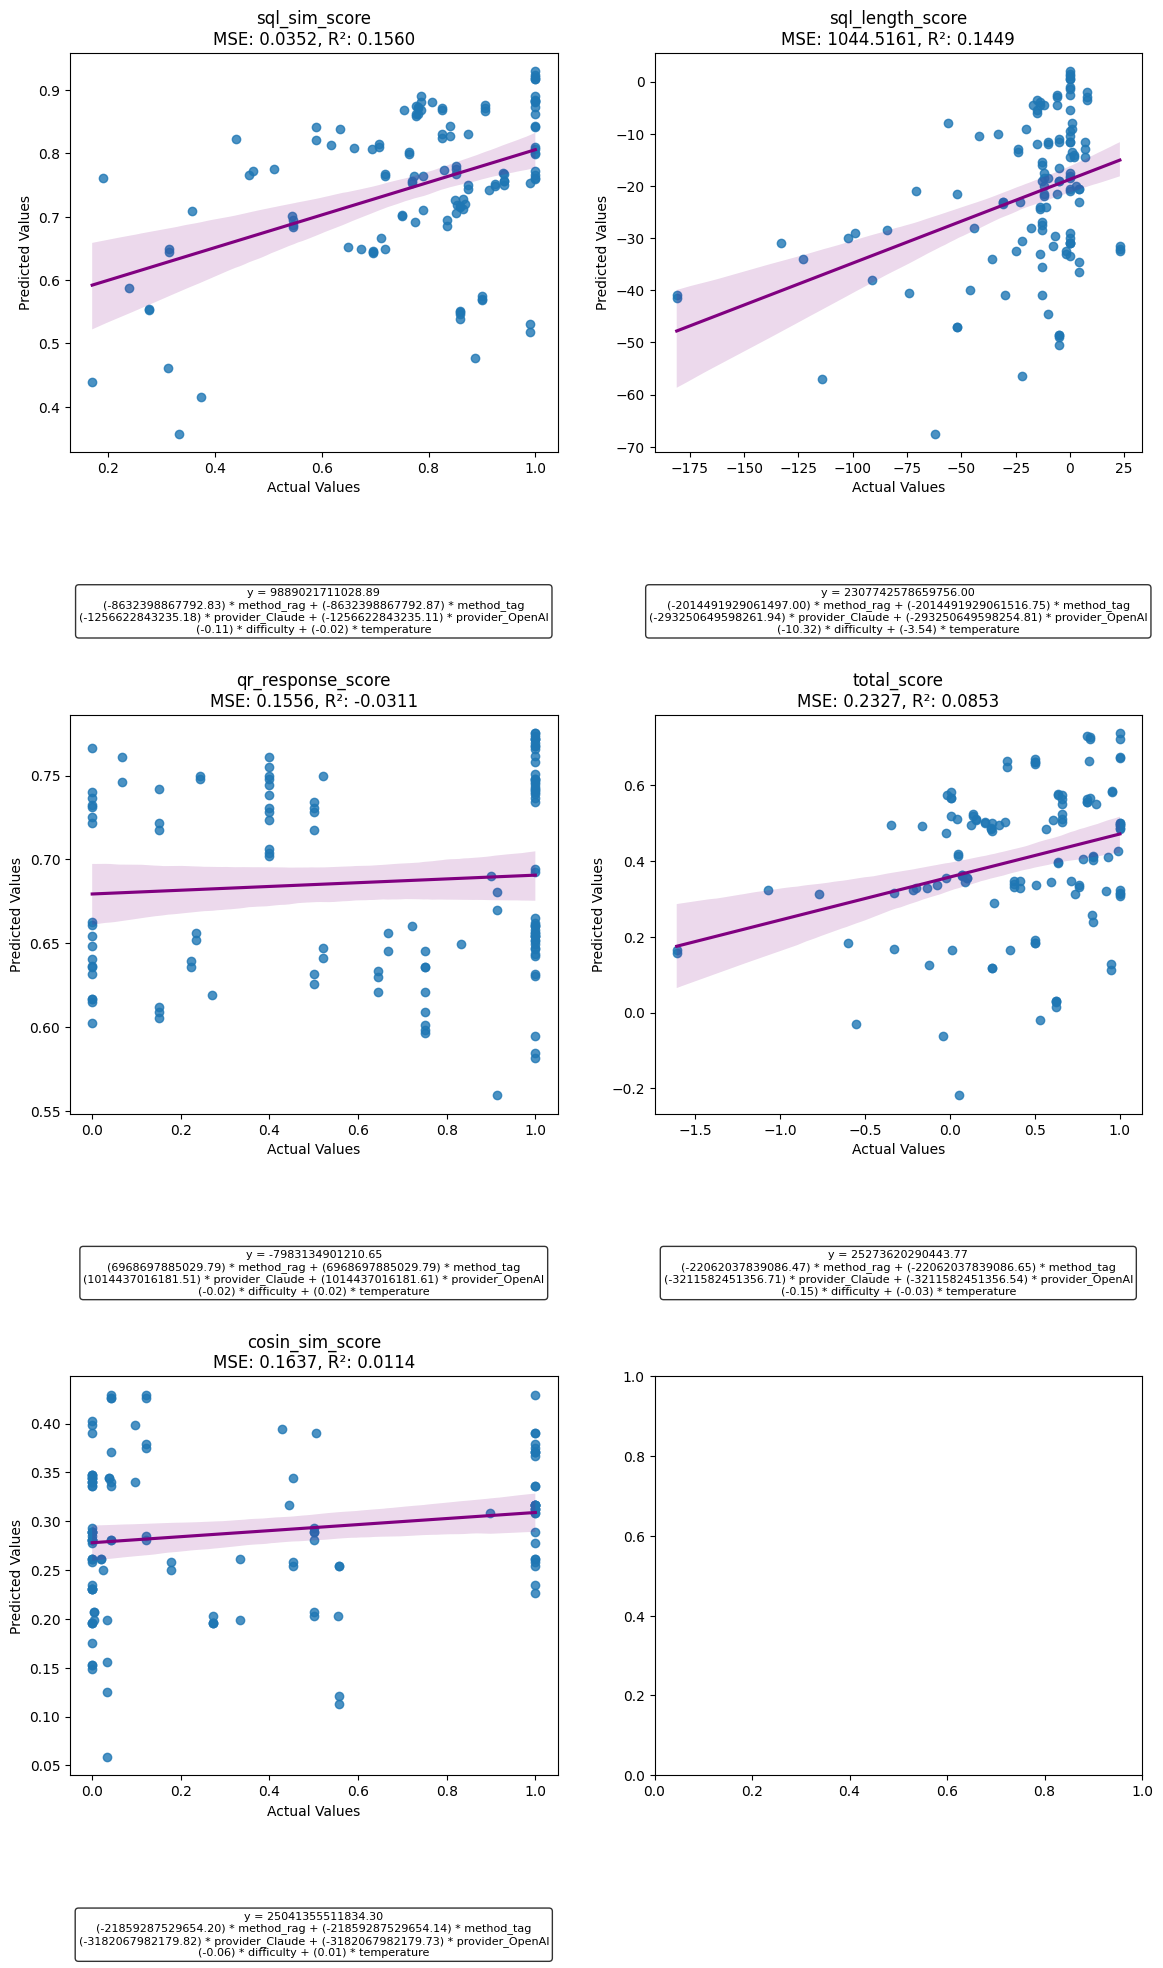

In [ ]:
# Linear regression for: ['difficulty', 'method', 'provider', 'temperature']
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(), ['method', 'provider']),
    ],
    remainder='passthrough' 
)


def analyze_and_sub_plot(ax, response_var):

    X = sql_df[['difficulty', 'method', 'provider', 'temperature']]
    y = sql_df[response_var]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('regressor', LinearRegression())
    ])
    
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)

    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    transformed_feature_names = pipeline.named_steps['preprocessor'].transformers_[0][1].get_feature_names_out()
    passthrough_features = ['difficulty', 'temperature']  # Manually add passthrough features
    all_feature_names = list(transformed_feature_names) + passthrough_features
    coefficients = pipeline.named_steps['regressor'].coef_
    intercept = pipeline.named_steps['regressor'].intercept_
   
    terms = [f"({coef:.2f}) * {feature}" for feature, coef in zip(all_feature_names, coefficients)]
    formula_lines = [f"y = {intercept:.2f}"]
    for i in range(0, len(terms), 2):  # Group terms in chunks of 3
        formula_lines.append(" + ".join(terms[i:i + 2]))
    formatted_formula = "\n".join(formula_lines)  # Join lines with explicit line breaks

    print("current formula: ", formatted_formula)

    results_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})

    sns.regplot(data=results_df, x='Actual', y='Predicted', ax=ax, line_kws={'color': 'purple'})
    ax.set_title(f'{response_var}\nMSE: {mse:.4f}, R²: {r2:.4f}')
    ax.set_xlabel('Actual Values')
    ax.set_ylabel('Predicted Values')
    
    ax.text(
        0.5, -0.4, formatted_formula, fontsize=8, ha='center', va='center', transform=ax.transAxes,
        bbox=dict(boxstyle="round", facecolor="white", alpha=0.8)
    )

fig, axes = plt.subplots(3, 2, figsize=(12, 20)) 

response_variables = ['sql_sim_score', 'sql_length_score', 'qr_response_score', 'total_score', 'cosin_sim_score']

for i, var in enumerate(response_variables):
    row, col = divmod(i, 2)
    analyze_and_sub_plot(axes[row, col], var)

plt.tight_layout()
plt.show()


current formula:  y = 5979050381420.80
(-5113445173212.15) * method_rag + (-5113445173212.20) * method_tag
(-865605208207.78) * provider_Claude + (-865605208207.72) * provider_OpenAI
(-0.13) * difficulty + (-0.02) * temperature
(0.07) * specified_response_field
current formula:  y = 2158379610059512.00
(-1845904465584604.50) * method_rag + (-1845904465584624.75) * method_tag
(-312475144474910.44) * provider_Claude + (-312475144474902.94) * provider_OpenAI
(-10.96) * difficulty + (-3.29) * temperature
(3.65) * specified_response_field
current formula:  y = -11969801435755.43
(10236897077532.18) * method_rag + (10236897077532.18) * method_tag
(1732904358223.89) * provider_Claude + (1732904358223.99) * provider_OpenAI
(-0.03) * difficulty + (0.02) * temperature
(0.03) * specified_response_field
current formula:  y = 20804809482799.40
(-17792834286864.03) * method_rag + (-17792834286864.23) * method_tag
(-3011975195934.78) * provider_Claude + (-3011975195934.61) * provider_OpenAI
(-0.16) *

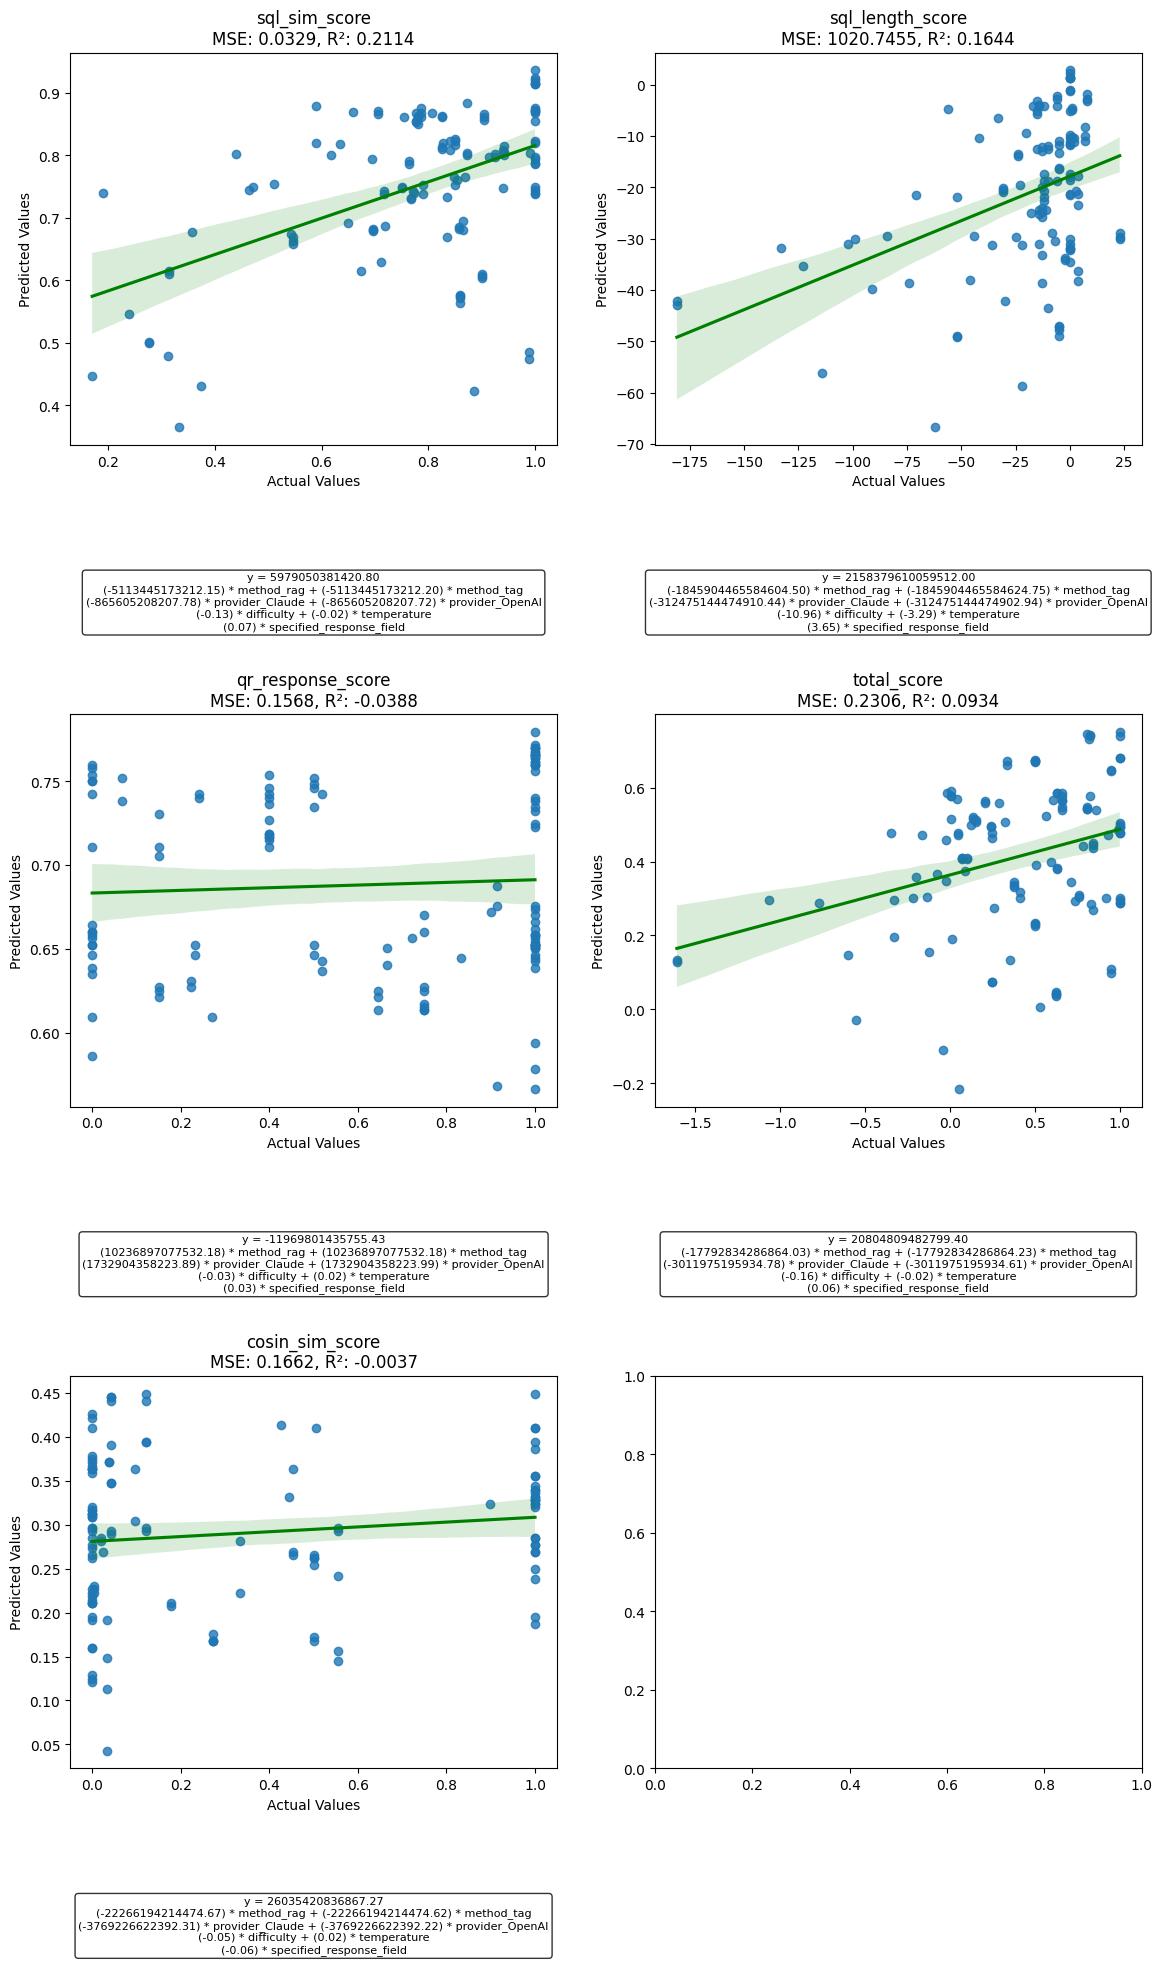

In [ ]:
# Linear regression for: ['difficulty', 'method', 'provider', 'temperature']
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(), ['method', 'provider']),
    ],
    remainder='passthrough'  # Keep numerical and binary features as they are
)

def analyze_and_sub_plot(ax, response_var):

    X = sql_df[['difficulty', 'method', 'provider', 'temperature', 'specified_response_field']]
    y = sql_df[response_var]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    

    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('regressor', LinearRegression())
    ])
    
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)

    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    transformed_feature_names = pipeline.named_steps['preprocessor'].transformers_[0][1].get_feature_names_out()
    passthrough_features = ['difficulty', 'temperature', 'specified_response_field']  # Manually add passthrough features
    all_feature_names = list(transformed_feature_names) + passthrough_features
    coefficients = pipeline.named_steps['regressor'].coef_
    intercept = pipeline.named_steps['regressor'].intercept_
  
    terms = [f"({coef:.2f}) * {feature}" for feature, coef in zip(all_feature_names, coefficients)]
    formula_lines = [f"y = {intercept:.2f}"]
    for i in range(0, len(terms), 2):  # Group terms in chunks of 2
        formula_lines.append(" + ".join(terms[i:i + 2]))
    formatted_formula = "\n".join(formula_lines)  # Join lines with explicit line breaks

    print("current formula: ", formatted_formula)

    results_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})

    sns.regplot(data=results_df, x='Actual', y='Predicted', ax=ax, line_kws={'color': 'green'})
    ax.set_title(f'{response_var}\nMSE: {mse:.4f}, R²: {r2:.4f}')
    ax.set_xlabel('Actual Values')
    ax.set_ylabel('Predicted Values')
    
    ax.text(
        0.5, -0.4, formatted_formula, fontsize=8, ha='center', va='center', transform=ax.transAxes,
        bbox=dict(boxstyle="round", facecolor="white", alpha=0.8)
    )


fig, axes = plt.subplots(3, 2, figsize=(12, 20))  # 2x2 layout for 4 response variables

response_variables = ['sql_sim_score', 'sql_length_score', 'qr_response_score', 'total_score', 'cosin_sim_score']

for i, var in enumerate(response_variables):
    row, col = divmod(i, 2)
    analyze_and_sub_plot(axes[row, col], var)

plt.tight_layout()
plt.show()